## Pendulum Dynamics

In [1]:
import ipywidgets as widgets
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import time

#from pendulum_animation import make_animation

from matplotlib import rc #,animation
import matplotlib.animation as animation
from collections import deque
from IPython.display import HTML

In [2]:
from P2_MS1 import functions_ms #_ocp_without_timeparameter
from P2_MS4 import solve_nlp

from animate import get_cart_x, get_cart_y, get_ball_x, get_ball_y, animate_pendulum

In [3]:
from MS2_Leo import nmpc

# Implementing the Pendulum Dynamics

In [4]:
file = open("./Pendulum_graphic.png", "rb")
image = file.read()
widgets.Image(
    value=image,
    format='png',
    width=200,
    height=30,
)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xb1\x00\x00\x01\xd2\x08\x06\x00\x00\x00b\xb0\xf5…

In [5]:
# our parameters !
m = 1
M = 2
l = 0.2 # attention! l must be also changed in the animate.py file!
g = 9.81

In [6]:
# defining the rhs of the ODE system

# state variables
x1 = MX.sym('x1') #r
x2 = MX.sym('x2') #rdot
x3 = MX.sym('x3') #theta
x4 = MX.sym('x4') #thetadot
x = vertcat(x1,x2,x3,x4)

# control variable
u = MX.sym('u')

# rhs
rhs_exp = vertcat(x2,
             (-m*g*cos(x3)*sin(x3)-m*l*x4*x4*sin(x3)+u)/(M+m*sin(x3)*sin(x3)),
             x4,
             -g/l*sin(x3)+ cos(x3)/l*((-m*g*cos(x3)*sin(x3)-m*l*x4*x4*sin(x3)+u)/(M+m*sin(x3)*sin(x3))))

rhs = Function('rhs',[x,u],[rhs_exp])


# Simulating a good initial guess

In [7]:
###extra feature time grid in shooting intervals for better animation
M = 1 # time grid
N = 20 # number of integration steps
T = 2

in_control = np.array([15,-90,90,-90,75,  #good simulation results
                  -5,24,-19,0,0,
                  15,-15,15,-15,15,
                  -15,25,-25,20,-20])

#eps =0.01
s0 = [0, 0, 0, 0]
Res1 = s0

dae = {'x': x, 'p': u, 'ode': rhs_exp}
opts = {'tf': T/N}#{'grid':np.linspace(0,T,M)}
F = integrator('F', 'cvodes', dae, opts)

for i in range(N):
    Fi = F(x0=s0, p=in_control[i])
    Xk_end = Fi['xf']
    for k in range(1,M+1):
        Res1 = vertcat(Res1,Xk_end[:,k-1])
    s0 = Xk_end[:,M-2]
#print(Res1.shape)
#print(Res1)
#print(np.array(Res1).flatten().shape[0])


MovieWriter Pillow unavailable; using Pillow instead.


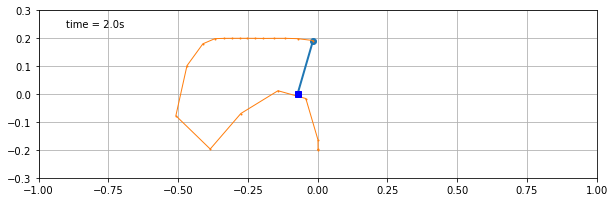

In [8]:
animate_pendulum("initialAnimation.gif", Res1)

# Posing an optimal control problem

In [9]:
# formulating the OCP

gamma = 0.
delta = 0.

L_exp = (x3-pi)*(x3-pi)
Lp_exp = (x3-pi)*(x3-pi) + gamma*u*u + delta*x1*x1
M_exp = 0

#todo control constraints
cc_exp=vertcat(u+100,100-u)

#todo initial and terminal constraints
s0 = MX.sym('s0',4)
sm = MX.sym('sm',4)
meas = MX.sym('meas',4)
bc_exp = vertcat(sm[2]-pi,sm[3],s0[0],s0[1],s0[2],s0[3]) ## do we need terminal constraints, yes, or the cart will speed up
bc_mod_exp = vertcat(s0[0]-meas[0],s0[1]-meas[1],s0[2]-meas[2],s0[3]-meas[3])

#todo state constraints
statec_exp = vertcat(x[0]+0.7,-x[0]+0.7,-x[1]+22,x[1]+22)

L = Function('L', [x],[L_exp])
Lp = Function('Lp', [x,u],[Lp_exp])
M = Function('M', [x],[M_exp])
bc = Function('bc', [vertcat(s0,sm,meas)],[bc_exp])
bc_mod = Function('bc_mod', [vertcat(s0,sm,meas)],[bc_mod_exp])
statec = Function('statec',[x],[statec_exp])
cc = Function('cc', [u], [cc_exp])

# MS1: Solving the Open Loop Problem

## Solving with for T=1 and ipopt

In [10]:
# we use T=1 with 10 shooting intervals
s = np.array(Res1).flatten()
w01 = vertcat(in_control[0:10], s[0:44])

In [11]:
# Open loop with ipopt
NN = 10 #no. of shooting intervals
m = 1 # 1d control

tt1, tt2, tt3, len_w = functions_ms(NN, x, u, rhs, Lp, bc, statec, cc, T=1)


meas0 = [0,0,0,0]
w = MX.sym('w',len_w)
t1 = Function('t1', [w], [tt1(w,meas0)])
t2 = Function('t2', [w], [tt2(w,meas0)])
t3 = Function('t3', [w], [tt3(w,meas0)])

w0=np.ones(len_w)

uu1, ss1, wlam11, wmu11 = solve_nlp(NN,m,t1,t2,t3,w01, itmax=200, tol=1e-7, sqp = False, store_iteration = False, time_parameter=False, verbose=False)

Multiple shooting discretization started....
Multiple shooting discretization done....
dimension of w:  54

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  49.00ms (  1.96ms)  49.46ms (  1.98ms)        25
       nlp_g  |  57.00ms (  2.28ms)  56.27ms (  2.25ms)        25
  nlp_grad_f  | 402.00ms ( 15.46ms) 399.14ms ( 15.35ms)        26
  nlp_hess_l  |   6.10 s (254.21ms)   6.10 s (254.23ms)        24
   nlp_jac_g  | 842.00ms ( 32.38ms) 844.19ms ( 32.47ms)        26
       total  |   7.47 s (  7.47 s)   7.47 s (  7.47 s)         1


MovieWriter Pillow unavailable; using Pillow instead.


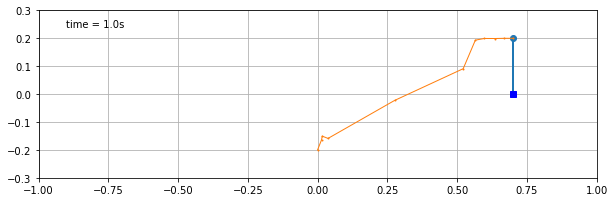

In [12]:
animate_pendulum("ipoptT=1.gif", ss1)

## Solving with T=2 and ipopt

In [13]:
# we use T = 2 with 20 shooting intervals
s = np.array(Res1).flatten()
w01 = vertcat(in_control, s)
#print(w01)
#print(w01.shape)

In [18]:
# Open loop with ipopt
NN = 20 #no. of shooting intervals
m = 1 # 1d control

tt1, tt2, tt3, len_w = functions_ms(NN, x, u, rhs, Lp, bc_mod, statec, cc, T=2)

meas0 = [0,0,0,0]#[0,0,0,0]
w = MX.sym('w',len_w)
t1 = Function('t1', [w], [tt1(w,meas0)])
t2 = Function('t2', [w], [tt2(w,meas0)])
t3 = Function('t3', [w], [tt3(w,meas0)])

w0=np.ones(len_w)

uu, ss, wlam1, wmu1 = solve_nlp(NN,m,t1,t2,t3,w0, itmax=200, tol=1e-7, sqp = False, store_iteration = False, time_parameter=False, verbose=False)

Multiple shooting discretization started....
Multiple shooting discretization done....
dimension of w:  104
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 347.00ms (  4.13ms) 346.56ms (  4.13ms)        84
       nlp_g  | 340.00ms (  4.05ms) 339.19ms (  4.04ms)        84
  nlp_grad_f  |   2.07 s ( 27.61ms)   2.07 s ( 27.59ms)        75
  nlp_hess_l  |  31.55 s (432.16ms)  31.55 s (432.18ms)        73
   nlp_jac_g  |   4.47 s ( 59.59ms)   4.47 s ( 59.63ms)        75
       total  |  38.84 s ( 38.84 s)  38.84 s ( 38.84 s)         1


MovieWriter Pillow unavailable; using Pillow instead.


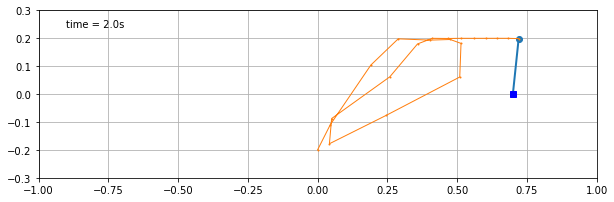

In [19]:
animate_pendulum("ipoptAnimationones.gif",ss)

## Solving with T=2 and our sqp

In [20]:
# Open loop with sqp
NN = 20 #no. of shooting intervals
m = 1 # 1d control

tt1, tt2, tt3, len_w = functions_ms(NN, x, u, rhs, Lp, bc_mod, statec, cc, T=2)

meas0 = [0,0,0,0]
w = MX.sym('w',len_w)
t1 = Function('t1', [w], [tt1(w,meas0)])
t2 = Function('t2', [w], [tt2(w,meas0)])
t3 = Function('t3', [w], [tt3(w,meas0)])


w0=np.ones(len_w)
w02 = vertcat(uu,ss)

uu2, ss2, wlam2, wmu2 = solve_nlp(NN,m,t1,t2,t3,w02, itmax=200, tol=1e-7, sqp = True,lam0=wlam1,mu0=wmu1, store_iteration = False, time_parameter=False, verbose=False)

Multiple shooting discretization started....
Multiple shooting discretization done....
dimension of w:  104


MovieWriter Pillow unavailable; using Pillow instead.


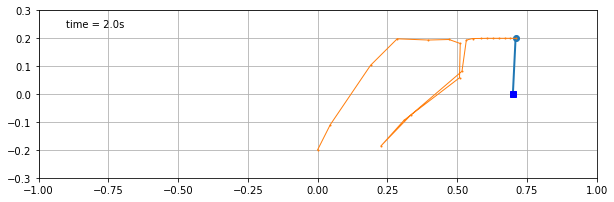

In [21]:
animate_pendulum("sqpAnimation.gif",ss2)

# NMPC with ipopt and T=1 with perturbations

In [22]:
T = 1
NN = 10
#w0 = vertcat(uu2[0:10], ss2[0:44])
w0 = vertcat(uu1,ss1)
meas0 = [0,0,0,0]

In [26]:
u_real1, s_real1, S0, S1 = nmpc(T,NN,w0,meas0,x, u, rhs, Lp, bc_mod, statec, cc, wlam11[2:], wmu11,per=0.3,sqp=False)

Multiple shooting discretization started....
Multiple shooting discretization done....
dimension of w:  54
starting of iteration no.  0
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  12.00ms (  6.00ms)  11.26ms (  5.63ms)         2
       nlp_g  |        0 (       0)        0 (       0)         2
  nlp_grad_f  |  45.00ms ( 15.00ms)  45.45ms ( 15.15ms)         3
  nlp_hess_l  | 234.00ms (234.00ms) 234.17ms (234.17ms)         1
   nlp_jac_g  |  96.00ms ( 32.00ms)  96.29ms ( 32.10ms)         3
       total  | 387.00ms (387.00ms) 387.17ms (387.17ms)         1
needed time in iteration0 0.505161199999975
starting of iteration no.  1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   6.00ms (  3.00ms)   6.12ms (  3.06ms)         2
       nlp_g  |   5.00ms (  2.50ms)   4.61ms (  2.31ms)         2
  nlp_grad_f  |  31.00ms ( 10.33ms)  31.24ms ( 10.41ms)         3
  nlp_hess_l  | 240.00ms (240.00ms) 239.77ms (239.77ms)         1

MovieWriter Pillow unavailable; using Pillow instead.


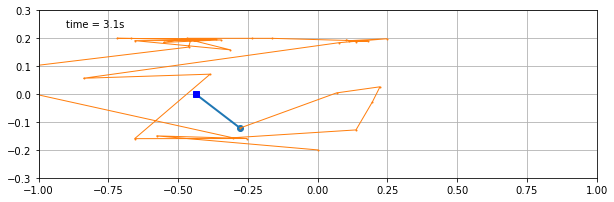

In [27]:
animate_pendulum("nmpc_ipopt_per.gif",s_real1)

In [ ]:
s_real1
SS = [6.81779200e-32,  5.48258329e-29,  4.20106951e-29, -1.48872574e-27,
 -2.50008362e-04, -5.26812618e-04, -9.76730779e-04,  1.11619883e-02,
  3.93030033e-03,  8.95340213e-02,  2.50317314e-02,  5.29619071e-01,
  1.29147175e-02,  6.54810898e-02,  5.13209893e-02, -1.73717669e-01,
  1.05182063e-02, -7.67132271e-02, -6.67629045e-02, -1.86607396e+00,
  8.18745337e-03,  3.32710777e-02, -2.23138879e-01, -9.03085201e-01,
 -1.54385771e-03, -1.88526208e-01, -2.94759284e-01, -6.41620300e-02,
 -1.45761460e-02, -1.66445642e-02, -1.07417479e-01,  3.88006767e+00,
  1.01112777e-02,  6.01832843e-01,  5.13225318e-01,  8.63162271e+00,
  1.33597651e-01,  1.79877726e+00,  1.78242983e+00,  1.61158454e+01,
  1.76496408e-01, -1.22421153e+00,  2.44498690e+00, -6.29911201e+00]

In [ ]:
#T = 0.5
#NN = 5
#w0 = vertcat(uu2[0:5], ss2[0:24])
#meas0 = [0,0,0,0]

In [ ]:
#u_real, s_real, S0,S1 = nmpc(T,NN,w0,meas0,x, u, rhs, Lp, bc_mod, statec, cc, np.ones(24), np.zeros(34),per=0,sqp=False)

In [ ]:
#animate_pendulum("nmpcAnimation.gif",s_real)

In [ ]:
#S = [ 6.81779200e-32,  0.00000000e+00, -3.05645082e-29,  1.49474620e-27,
#  6.75188508e-03,  1.35223882e-01,  3.25315430e-02,  6.29559757e-01,
#  2.77514945e-02,  2.82396311e-01,  1.21618901e-01,  1.07674755e+00,
#  5.34305085e-02,  2.13013172e-01,  1.69907197e-01, -2.54874496e-01,
#  6.18264290e-02, -1.94870424e-02,  1.29671690e-02, -2.61333105e+00,
#  5.61391430e-02, -6.26578980e-02, -2.68725495e-01, -2.45990246e+00]
#animate_pendulum("debugnmpc.gif",S)